# 1. Exploring and visualizing sentiment change in two-party conversation

During our initial meeting, the company that I consulted for proposed integrating a "sentiment track" into their call flow. The company aims to maximize performance of collections calls agents and flag any compliance regulations issues. Being able to assess sentiment of both parties - the Agent and the Borrower - on a call-by-call basis might enhance their ability to meet these goals.

Sentiment is typically assessed at the document level, but this would not meet their needs; they needed information about both parties, and ideally they would be able to assess sentiment at different time points during the conversation. To achieve this goal, I worked with VADER - a rule-based sentiment anlaysis tool and pre-trained lexicon - for this part of the project.

## 1.1. Using VADER for sentiment analysis of dialogue

After poking around for different options regarding sentiment analysis, I converged on the VADER sentiment analysis tool (https://github.com/cjhutto/vaderSentiment). VADER is a pre-trained lexicon that is specifically attuned to social media data. Although not social media data, the call transcripts that I worked with for this project were similar in a number of ways: each turn in the converstation is relatively short - an average of just 12 words per exchange - and the exchanges lack grammatical information (because they are talk-to-text without any punctuation). VADER also takes degree modifiers (intensifiers) into account when calculating sentiment score. For example, "I am so angry that you keep calling me" is rated as more negative than, "I am angry that you keep calling me". Given that I was implementing this on naturalistic text, it was important that intensifiers were considered in determining valence. 

Further, VADER is pre-trained so it doesn't require any training data (the transcripts were initially unlabeled for any sort of emotion). And because it doesn't require training dadta, VADER is fast and computationally cheap. The company is interested in one way integrating a sentiment track in real-time, and VADER would be able to do so with almost zero lag. As such, I calculated a VADER valence score for each t urn in the corpus, separately for Agents and Borrowers. 


## 1.2. Calculating sentiment change over time

For the current purposes, I focused on the compound score. The compound score is a normalized weight composite score of the sentiment for the each turn. It's calculated by summing the valence scores of each word in the lexicon and is normalized to be between -1 (negative) and +1 (positive). VADERS creators call this the "most useful metric if you want a single unidimensional measure of sentiment for a given sentence". 

When looking at the distributions of the compound score for both Agents and Borrowers, I found that both were skewed towards the positive end of the scale. This could be due to the nature of the conversations - conversations between strangers likely incorporate more positive sentiment than less formal conversations - and could also be due to that lexicons in general tend to be better at capturing positive emotion. 

After using VADER to find a compound score for each turn, I was left with a variable with a compound score for each speaker (Agent and Borrower) for each turn in each conversation. This is what I used to explore and characterize different kinds of sentiment flow in these conversations. 

Each turn had a time stamp for when each utterance was produced during a conversation. I normalized this variable to put all conversations on the same scale. I explored sentiment change in a couple of ways. I:
1. Created visualizations of how the sentiment changed over time for each conversation partner, and 
2. Created a sentiment change variable to plot how sentiment changes for each party. 

## 1.3. Characterizing different types of sentiment flows

From these visualizations, I then worked toward identifying different types of sentiment flows. 

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
#reading in the data
corpus = pd.read_csv('/Users/cah/anaconda3/envs/insight/Corpus_processed.csv', low_memory = False)

In [3]:
corpus.head()

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7


In [4]:
analyzer = SentimentIntensityAnalyzer()

In [31]:
#finding sentiment scores for the entire corpus
sent_scores = corpus.transcript.apply(analyzer.polarity_scores)

In [34]:
#appending the sentiment scores back in with the corpus
from collections import defaultdict
tmp = defaultdict(list)
for i,row in sent_scores.iteritems():
    for k in row:
        tmp[k].append(row[k])
        
tmp = pd.DataFrame(tmp)
corpus2 = pd.concat([corpus, tmp], axis=1)

In [37]:
corpus2.head()

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount,neg,neu,pos,compound,transcript_strip,speaker_cat
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12,0.0,0.787,0.213,0.4019,those recovery minutes name you thomas speakin...,Agent
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20,0.0,0.933,0.067,0.0772,hi angela this is katie the phone number one e...,Borrower
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3,0.0,0.208,0.792,0.4215,four worth okay,Agent
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1,0.0,0.000,1.000,0.2500,alright,Borrower
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7,0.0,0.725,0.275,0.2263,this it's i you get submit okay,Borrower


In [36]:
#corpus2['neg'] = corpus2['neg'].astype(int)
#corpus2['neu'] = corpus2['neu'].astype(int)
#corpus2['pos'] = corpus2['pos'].astype(int)
#corpus2['compound'] = corpus2['compound'].astype(int)
#corpus2['endTime'] = corpus2['endTime'].astype(int)
corpus2['transcript_strip'] = corpus2['transcript'].str.strip()
corpus2['speaker_cat'] = corpus2['speaker'].astype('category')
#corpus2.speaker_cat.cat.codes

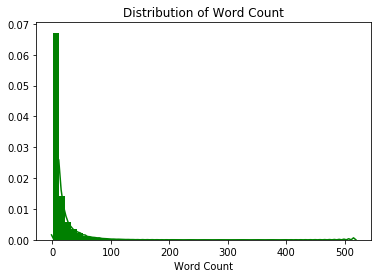

In [38]:
#word count distribution plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(corpus2['wordcount'], color='green', hist_kws=dict(alpha=1))
plt.xlabel('Word Count')
plt.title('Distribution of Word Count')
plt.show()

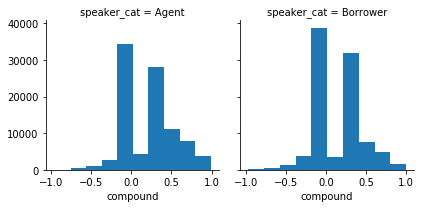

In [59]:
speaker_facet = sns.FacetGrid(corpus2, col="speaker_cat")
speaker_facet.map(plt.hist, "compound")

In [39]:
import matplotlib.pyplot as plt
call_ex1 = corpus2[(corpus2.callID == '0dbf3917-6b98-4cf2-907f-4532681bcf61')]

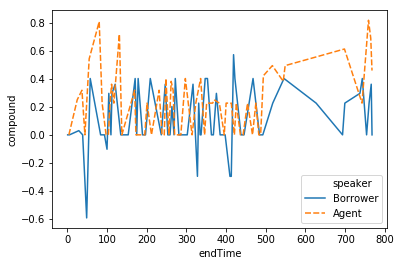

In [55]:
call_ex1_plot = sns.lineplot(x="endTime", y="compound", 
                             hue="speaker", style="speaker",
                             data=call_ex1)

In [49]:
agent_data = corpus2[(corpus2.speaker_cat == 'Agent')]
borrower_data = corpus2[(corpus2.speaker_cat == 'Borrower')]

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount,neg,neu,pos,compound,transcript_strip,speaker_cat
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20,0.0,0.933,0.067,0.0772,hi angela this is katie the phone number one e...,Borrower
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1,0.0,0.000,1.000,0.2500,alright,Borrower
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7,0.0,0.725,0.275,0.2263,this it's i you get submit okay,Borrower
6,6,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,6,Borrower,30.92,32.66,okay because that's not it was to l,NaN,8,0.0,0.759,0.241,0.2263,okay because that's not it was to l,Borrower
8,8,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,8,Borrower,33.97,35.07,i name,NaN,2,0.0,1.000,0.000,0.0000,i name,Borrower
